In [ ]:
import os
import argparse
import logging

In [ ]:
os.chdir('/home/joe/testbed/Counterfactual-Recurrent-Network')

# get synthetic counterfactual survival data, using cancer sim

In [ ]:
from utils import cancer_simulation

In [ ]:

def init_arg():
    parser = argparse.ArgumentParser()
    parser.add_argument("--chemo_coeff", default=2, type=int)
    parser.add_argument("--radio_coeff", default=2, type=int)
    parser.add_argument("--results_dir", default='results')
    parser.add_argument("--model_name", default="crn_test_2")
    parser.add_argument("--b_encoder_hyperparm_tuning", default=False)
    parser.add_argument("--b_decoder_hyperparm_tuning", default=False)
    #return parser.parse_args() 
    return parser.parse_args(args=[]) # to work in jupyter



In [ ]:
args = init_arg()


In [ ]:
pickle_map = cancer_simulation.get_cancer_sim_data(chemo_coeff=args.chemo_coeff, radio_coeff=args.radio_coeff, b_load=False,
                                          b_save=False, model_root=args.results_dir)

In [ ]:
pickle_map.keys()

In [ ]:
pickle_map['training_data'].keys()

In [ ]:
import numpy as np

In [ ]:

num_time_steps = 60  # 6 month followup
num_patients = 50

simulation_params = cancer_simulation.get_confounding_params(num_patients, chemo_coeff=5.0, radio_coeff=5.0)
simulation_params['window_size'] = 15

projection_horizon = 5
treatment_options = np.array(
    [[(1, 0), (0, 0), (0, 1), (0, 0), (0, 0)],
        [(0, 0), (1, 0), (0, 1), (0, 0), (0, 0)]])

outputs = cancer_simulation.simulate(simulation_params, num_time_steps)

#print(outputs['cancer_volume'][:10])
#print(outputs['chemo_probabilities'][:10])
#print(outputs['radio_probabilities'][:10])

# Plot patient

# plot_treatments(63)

print("fin")


In [ ]:
cancer_simulation.plot_treatments(9, outputs)

In [ ]:
cancer_simulation.plot_treatments(3, outputs)

In [ ]:
outputs.keys()

In [ ]:
outputs['sequence_lengths']

## these data are mostly right cnesored, todo tweak the parameters.
# now, model the survival times given the covariates, using DSM

In [ ]:
# what's X?
outputs['patient_types']

In [ ]:
outputs['cancer_volume'].shape

## ... wont work, because covariate vector only has one feature "patient_types". also, for those who are right censored, the cnesorship time is all exactly the same.

# testing SCIGAN

In [ ]:

def init_arg():
    parser = argparse.ArgumentParser()
    parser.add_argument("--num_treatments", default=3, type=int)
    parser.add_argument("--treatment_selection_bias", default=2.0, type=float)
    parser.add_argument("--dosage_selection_bias", default=2.0, type=float)
    parser.add_argument("--save_dataset", default=False)
    parser.add_argument("--validation_fraction", default=0.1, type=float)
    parser.add_argument("--test_fraction", default=0.2, type=float)
    parser.add_argument("--model_name", default="scigan_test")
    parser.add_argument("--verbose", default=False)
    parser.add_argument("--batch_size", default=128, type=int)
    parser.add_argument("--h_dim", default=64, type=int)
    parser.add_argument("--h_inv_eqv_dim", default=64, type=int)
    parser.add_argument("--num_dosage_samples", default=5, type=int)
    parser.add_argument("--alpha", default=1.0, type=float)

    return parser.parse_args(args=[])

In [ ]:
os.chdir('/home/joe/testbed/SCIGAN')

In [ ]:

import argparse
import os
import shutil
import tensorflow as tf

from data_simulation import get_dataset_splits, TCGA_Data
from SCIGAN import SCIGAN_Model
from utils.evaluation_utils import compute_eval_metrics

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)



In [ ]:

args = init_arg()

dataset_params = dict()
dataset_params['num_treatments'] = args.num_treatments
dataset_params['treatment_selection_bias'] = args.treatment_selection_bias
dataset_params['dosage_selection_bias'] = args.dosage_selection_bias
dataset_params['save_dataset'] = args.save_dataset
dataset_params['validation_fraction'] = args.validation_fraction
dataset_params['test_fraction'] = args.test_fraction


In [ ]:

data_class = TCGA_Data(dataset_params)
dataset = data_class.dataset
dataset_train, dataset_val, dataset_test = get_dataset_splits(dataset)


# DSM, exposing some learned representation

In [128]:
import os

In [129]:
os.chdir('/home/joe/testbed/DeepSurvivalMachines/')

In [130]:
from dsm import datasets
x, t, e = datasets.load_dataset('PBC', sequential = True)

In [133]:
import numpy as np
horizons = [0.25, 0.5, 0.75]
times = np.quantile([t_[-1] for t_, e_ in zip(t, e) if e_[-1] == 1], horizons).tolist()

In [134]:
horizons

[0.25, 0.5, 0.75]

In [135]:
n = len(x)

tr_size = int(n*0.70)
vl_size = int(n*0.10)
te_size = int(n*0.20)

x_train, x_test, x_val = np.array(x[:tr_size], dtype = object), np.array(x[-te_size:], dtype = object), np.array(x[tr_size:tr_size+vl_size], dtype = object)
t_train, t_test, t_val = np.array(t[:tr_size], dtype = object), np.array(t[-te_size:], dtype = object), np.array(t[tr_size:tr_size+vl_size], dtype = object)
e_train, e_test, e_val = np.array(e[:tr_size], dtype = object), np.array(e[-te_size:], dtype = object), np.array(e[tr_size:tr_size+vl_size], dtype = object)

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
param_grid = {'k' : [3, 4, 6],
              'distribution' : ['LogNormal', 'Weibull'],
              'learning_rate' : [1e-4, 1e-3],
              'hidden': [50, 100],
              'layers': [3, 2, 1],
              'typ': ['LSTM', 'GRU', 'RNN'],
             }
params = ParameterGrid(param_grid)

In [ ]:
from dsm import DeepRecurrentSurvivalMachines

In [ ]:
models = []
for param in params:
    #model = DeepRecurrentSurvivalMachines(k = param['k'],
    #                             distribution = param['distribution'],
    #                             hidden = param['hidden'], 
    #                             typ = param['typ'],
    #                             layers = param['layers'])
    ## The fit method is called to train the model
    #model.fit(x_train, t_train, e_train, iters = 1, learning_rate = param['learning_rate'])
    #models.append([[model.compute_nll(x_val, t_val, e_val), model]])
    continue

#best_model = min(models)
#model = best_model[0][1]

In [ ]:
param['layers'] = 3
param['typ'] = 'LSTM'
param

In [ ]:
model = DeepRecurrentSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 hidden = param['hidden'], 
                                 typ = param['typ'],
                                 layers = param['layers'])
# The fit method is called to train the model
model.fit(x_train, t_train, e_train, iters = 1, learning_rate = param['learning_rate'])

In [ ]:
x_train[0].shape

# now, try it on the mimic data

In [ ]:
os.chdir('../mimic_understander')

In [ ]:
import pandas as pd

In [ ]:
static_vars = pd.read_csv('./data/interim/static_vars.csv')

In [ ]:
dynamic_vars = pd.read_csv('./data/interim/dynamic_vars.csv')

In [ ]:
outcome_vars = pd.read_csv('./data/interim/outcome_vars.csv')

In [ ]:
input_vars = pd.read_csv('./data/interim/input_vars.csv')

In [ ]:
static_vars.shape

In [ ]:
import umap

In [ ]:
reducer = umap.UMAP()


In [ ]:
id_vars = ['subject_id','hadm_id','stay_id']

In [ ]:
dynamic = dynamic_vars.head(1000).set_index(id_vars).values

In [ ]:
dynamic_umap = reducer.fit_transform(dynamic)

In [ ]:
import seaborn as sns

In [ ]:
dynamic_umap.shape

In [ ]:
sns.scatterplot(dynamic_umap[:,0], dynamic_umap[:,1])

In [ ]:
outcomes_matched = pd.merge(dynamic_vars.head(1000), outcome_vars, how='inner', on=id_vars)[['los', 'mort_icu','hospital_expire_flag']]

In [ ]:
outcomes_matched

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.scatter(
    dynamic_umap[:,0], dynamic_umap[:,1],
    c=[sns.color_palette()[x] for x in outcomes_matched['mort_icu']])

## joining it with dsm

In [ ]:
model = DeepRecurrentSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 hidden = param['hidden'], 
                                 typ = param['typ'],
                                 layers = param['layers'])
# The fit method is called to train the model
#model.fit(x_train, t_train, e_train, iters = 1, learning_rate = param['learning_rate'])

In [ ]:
dynamic_vars.head()

In [ ]:
outcome_vars.head()

In [ ]:
id_vars = ['subject_id','hadm_id','stay_id']

In [ ]:
dynamic_outcome_matched = pd.merge(dynamic_vars.head(10000), outcome_vars, on=id_vars)

In [ ]:
dynamic_outcome_matched.head(10000)

In [ ]:
feat_names = list(dynamic_vars.set_index(id_vars).columns)

In [ ]:
model.fit(x_train, t_train, e_train, iters = 1, learning_rate = param['learning_rate'])

In [ ]:
x_af_train = []
t_af_train = []
e_af_train = []

for name, group in dynamic_outcome_matched.groupby(id_vars):
    if(len(group) > 1):
        x_af_train.append(group[feat_names].values)
        t_af_train.append(group['los'].values)
        e_af_train.append(group['hospital_expire_flag'].values)

x_af_train = np.array(x_af_train)
t_af_train = np.array(t_af_train)
e_af_train = np.array(e_af_train)

In [ ]:
model = DeepRecurrentSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 hidden = param['hidden'], 
                                 typ = param['typ'],
                                 layers = param['layers'])
# The fit method is called to train the model
model.fit(x_train, t_train, e_train, iters = 1, learning_rate = param['learning_rate'])

In [ ]:
model_fitted, embedding = model.fit(x_af_train, t_af_train, e_af_train, iters = 3, learning_rate = param['learning_rate'])

In [ ]:
model_fitted, embedding = model.fit(x_train, t_train, e_train, iters = 3, learning_rate = param['learning_rate'])

In [ ]:
len(x_af_train)

In [ ]:
(x_train, t_train, e_train,
            x_val, t_val, e_val) = model_fitted._prepocess_training_data(x_af_train, t_af_train, e_af_train, vsize=0.2, val_data=None, random_state = 3)

In [ ]:
x_train.view

In [ ]:
model_fitted.torch_model.embedding(x_train)

In [ ]:
model_fitted

# replicating AC TPC with torhc and reasonable libraries

## first, the data

In [1]:
import os
os.chdir('/home/joe/testbed/AC_TPC')

In [2]:
import numpy as np

In [3]:
data = np.load('./data/sample/data.npz')

In [4]:
data_x = data['data_x']
data_y = data['data_y']
y_type = data['y_type']

In [5]:
data_x.shape

(1346, 23, 35)

In [6]:
import torch
import tqdm

In [7]:
data_y.shape

(1346, 23, 3)

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
bs = 128 # batch size

In [10]:
torch.cuda.is_available()

True

In [11]:
n_iter = 30

In [12]:

def prepocess_training_data_chirag(x, y, vsize, random_state):
    """RNNs require different preprocessing for variable length sequences"""

    idx = list(range(x.shape[0]))
    np.random.seed(random_state)
    np.random.shuffle(idx)

    x_train, y_train = x[idx], y[idx]

    x_train = torch.from_numpy(x_train).float()
    y_train = torch.from_numpy(y_train).float()


    vsize = int(vsize*x_train.shape[0])

    x_val, y_val = x_train[-vsize:], y_train[-vsize:]

    x_train = x_train[:-vsize]
    y_train = y_train[:-vsize]

    return (x_train, y_train,
            x_val, y_val)



## next, the network components

In [170]:
class temp_layer_f(nn.Module):
    def __init__(self, hidden_size=8):
        super(temp_layer_f, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(35, self.hidden_size, num_layers=1, batch_first=True)
        self.dense = nn.Linear(self.hidden_size, self.hidden_size)
    def forward(self, x):
        lstm_output, (h_n, c_n) = self.lstm(x)
        x = lstm_output
        #x = self.dense(x)
        return x

class temp_layer_g(nn.Module):
    def __init__(self):    
        super(temp_layer_g, self).__init__()
        self.lstm = nn.LSTM(8, 8, num_layers=1, batch_first=True)
        self.dense1 = nn.Linear(8, 8)
        self.dense2 = nn.Linear(8, 8)
        self.dense3 = nn.Linear(8, 3)
        self.relu = nn.ReLU6()
        self.softmax = nn.Softmax(dim=2)
        self.dropout = nn.Dropout()
    def forward(self, x):
        x = self.lstm(x)[0] # can't we omit this from g?
        x = self.relu(x)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.dense3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.softmax(x)
        return x


In [171]:
bs = 128 # batch size
nbatches = int(x_train.shape[0]/bs)+1

In [172]:
x_train, y_train, x_val, y_val = prepocess_training_data_chirag(data_x, data_y, vsize=0.25, random_state=563)

In [173]:
y_train_bozo = (x_train[:,:,0:3] > 55) * 1.0
y_train_bozo[:,:,0] = 1.0
#y_train_bozo

In [174]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [175]:
yb.shape

torch.Size([114, 23, 3])

In [346]:
optimizer = torch.optim.Adam(
        [{'params': tf.parameters()},
        {'params': tg.parameters()}]
        , lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss(reduction='mean')

val_auc = 0.0

pbar = tqdm.tqdm(range(50))
for i in pbar:
    for j in range(nbatches):
        xb = x_train[j*bs:(j+1)*bs]
        yb = y_train[j*bs:(j+1)*bs]
        
        yb_preds = tg(tf(xb))

        optimizer.zero_grad()
        loss = loss_fn(yb_preds, yb)
        loss.backward()
        optimizer.step()
        
        auc = roc_auc_score(yb.view(-1).detach().numpy(), yb_preds.view(-1).detach().numpy())
        loss_value = loss.detach().numpy()
        pbar.set_postfix_str("loss = {:1.3f}, auc = {:.2f}, val_auc = {:.2f}".format(
            loss_value,
            auc,
            val_auc))
    
    val_preds = tg(tf(x_val))
    val_auc = roc_auc_score(y_val.view(-1).detach().numpy(), val_preds.view(-1).detach().numpy())


100%|██████████| 50/50 [00:10<00:00,  4.80it/s, loss = 0.799, auc = 0.79, val_auc = 0.73]


In [178]:
xb.shape

torch.Size([114, 23, 35])

In [179]:
class temp_layer_h(nn.Module):
    def __init__(self, K=3):    
        super(temp_layer_h, self).__init__()
        self.dense1 = nn.Linear(8, 64)
        self.dense2 = nn.Linear(64, 64)
        self.dense3 = nn.Linear(64, K)
        self.softmax = nn.Softmax()
    def forward(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.softmax(x)
        return x

In [348]:
class temp_layer_h_gumbo(nn.Module):
    def __init__(self, K=64):    
        super(temp_layer_h_gumbo, self).__init__()
        self.k = K
        self.dense_in = nn.Linear(8, K)
        #gumbo here
        self.dense_out = nn.Linear(K, 8)
        self.softmax = nn.Softmax(dim=2)
    def forward(self, x):
        x = self.dense_in(x)
        x = F.gumbel_softmax(x, tau=0.5, hard=True)
        x = self.dense_out(x)
        x = self.softmax(x)
        return x

In [349]:
#th = temp_layer_h()


In [226]:
tf(xb).shape

torch.Size([114, 23, 8])

In [227]:
tg(th(tf(xb))).shape

torch.Size([114, 23, 3])

In [203]:
#F.gumbel_softmax(logits, tau=0.5, hard=False)
print(F.gumbel_softmax(nn.Linear(8, 64)(tf(xb)), tau=0.5, hard=True).shape)
F.gumbel_softmax(nn.Linear(8, 64)(tf(xb)), tau=0.5, hard=True).sum(dim=2)

torch.Size([114, 23, 64])


tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], grad_fn=<SumBackward1>)

In [212]:
bozo = F.gumbel_softmax(nn.Linear(8, 64)(tf(xb)), tau=0.5, hard=True)

In [213]:
bozo.shape

torch.Size([114, 23, 64])

In [ ]:

tf = temp_layer_f()
tg = temp_layer_g()

In [295]:

th = temp_layer_h_gumbo(K=16)

In [347]:
optimizer = torch.optim.Adam(
        [{'params': tf.parameters()},
        {'params': tg.parameters()},
        {'params': th.parameters()}]
        , lr=1e-3)

optimizer = torch.optim.Adam(
        [
        {'params': th.parameters()}]
        , lr=1e-3)

loss_fn = nn.BCEWithLogitsLoss(reduction='mean')

val_auc = 0.0
val_auc_squeezed = 0.0


n_epochs = 50

metrics_record = pd.DataFrame(columns=["loss","auc","val_auc","auc_squeezed","val_auc_squeezed"],
            index=np.arange(0, n_epochs), dtype=np.float64)

pbar = tqdm.tqdm(range(n_epochs))
for i in pbar:
    for j in range(nbatches):
        xb = x_train[j*bs:(j+1)*bs]
        yb = y_train[j*bs:(j+1)*bs]
        
        yb_preds = tg(tf(xb))
        yb_preds_squeezed = tg(th(tf(xb)))

        optimizer.zero_grad()
        loss = loss_fn(yb_preds, yb) + loss_fn(yb_preds_squeezed, yb)
        #loss = loss_fn(yb_preds_squeezed, yb)
        loss.backward()
        optimizer.step()
        
        auc = roc_auc_score(yb.view(-1).detach().numpy(),
                            yb_preds.view(-1).detach().numpy())
        
        auc_squeezed = roc_auc_score(yb.view(-1).detach().numpy(),
                            yb_preds_squeezed.view(-1).detach().numpy())    

        loss_value = loss.detach().double().numpy()

        pbar.set_postfix_str("loss = {:1.3f}, auc = {:.2f}, val_auc = {:.2f}, auc_squeezed = {:.2f}, val_auc_squeezed = {:.2f}".format(
            loss_value,
            auc,
            val_auc,
            auc_squeezed,
            val_auc_squeezed))
    
    val_preds = tg(tf(x_val))
    val_preds_squeezed = tg(th(tf(x_val)))

    val_auc = roc_auc_score(y_val.view(-1).detach().numpy(), val_preds.view(-1).detach().numpy())
    val_auc_squeezed = roc_auc_score(y_val.view(-1).detach().numpy(), val_preds_squeezed.view(-1).detach().numpy())

    metrics_record.iloc[i] = [loss_value,
            auc,
            val_auc,
            auc_squeezed,
            val_auc_squeezed]

metrics_record['epoch'] = metrics_record.index + 1



100%|██████████| 50/50 [00:19<00:00,  2.54it/s, loss = 1.625, auc = 0.77, val_auc = 0.74, auc_squeezed = 0.60, val_auc_squeezed = 0.61]


In [299]:
import seaborn as sns

In [307]:
sns.lineplot(data=metrics_record, x='auc', y='loss')

TypeError: unhashable type: 'numpy.ndarray'

In [316]:
sns.scatterplot(data=metrics_record, x='auc',y='loss')

TypeError: unhashable type: 'numpy.ndarray'

In [339]:
type(val_auc_squeezed)

numpy.float64

In [328]:
metrics_record.head()

,loss,auc,val_auc,auc_squeezed,val_auc_squeezed,epoch
0,0.8315868377685547,0.68157,0.654938,0.543788,0.561392,0
1,0.8283392786979675,0.686857,0.661875,0.575056,0.575411,1
2,0.8272289037704468,0.685131,0.662395,0.580942,0.58672,2
3,0.8229969143867493,0.693565,0.658607,0.61598,0.601376,3
4,0.8231983780860901,0.690838,0.645184,0.611364,0.608414,4


In [337]:
metrics_record.auc

0      0.68157
1     0.686857
2     0.685131
3     0.693565
4     0.690838
5     0.674062
6      0.68229
7     0.686993
8     0.679789
9     0.684686
10    0.692717
11    0.677978
12    0.701763
13    0.681454
14    0.696777
15    0.671474
16    0.682071
17     0.68458
18    0.677794
19     0.67528
20    0.683163
21    0.679975
22     0.69006
23    0.672324
24    0.680418
25    0.681304
26    0.683673
27    0.697189
28    0.687749
29     0.68549
30    0.680976
31    0.666782
32    0.670037
33    0.672211
34    0.701261
35    0.666874
36    0.694541
37    0.674687
38    0.685937
39    0.684601
40    0.681084
41    0.687252
42    0.673533
43    0.682042
44    0.688148
45    0.688839
46    0.685085
47    0.697058
48    0.692103
49    0.677971
Name: auc, dtype: object

In [331]:
temp = metrics_record[['epoch','auc','loss','val_auc']]

<AxesSubplot:xlabel='epoch', ylabel='auc'>

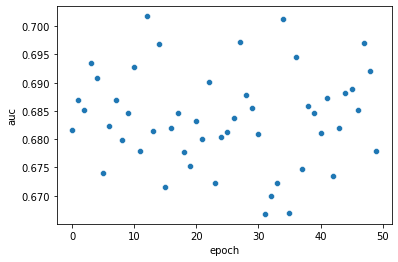

In [334]:
sns.scatterplot(data=metrics_record, x='epoch',y='auc')

<AxesSubplot:xlabel='year', ylabel='passengers'>

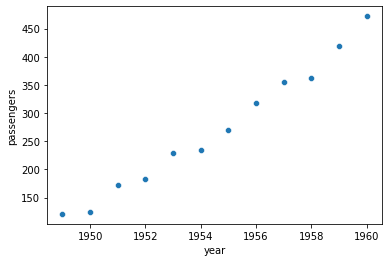

In [314]:
flights = sns.load_dataset("flights")
flights.head()
may_flights = flights.query("month == 'May'")
sns.scatterplot(data=may_flights, x="year", y="passengers")

In [313]:
may_flights

,year,month,passengers
4,1949,May,121
16,1950,May,125
28,1951,May,172
40,1952,May,183
52,1953,May,229
64,1954,May,234
76,1955,May,270
88,1956,May,318
100,1957,May,355
112,1958,May,363


In [273]:
pd.DataFdict(metrics_record.iloc[-1])

{'loss': array(1.6264865, dtype=float32),
 'auc': 0.7572912158043593,
 'val_auc': 0.7102983124679154,
 'auc_squeezed': 0.6164442815299876,
 'val_auc_squeezed': 0.6228909400536126}

In [277]:
def training_loop_iter_K(K):
    th_iter = temp_layer_h_gumbo(K=K)
    optimizer = torch.optim.Adam(
        [{'params': tf.parameters()},
        {'params': tg.parameters()},
        {'params': th_iter.parameters()}]
        , lr=1e-3)
    loss_fn = nn.BCEWithLogitsLoss(reduction='mean')

    val_auc = 0.0
    val_auc_squeezed = 0.0


    n_epochs = 50

    metrics_record = pd.DataFrame(columns=["loss","auc","val_auc","auc_squeezed","val_auc_squeezed"],
                index=np.arange(0, n_epochs))

    pbar = tqdm.tqdm(range(n_epochs))
    for i in pbar:
        for j in range(nbatches):
            xb = x_train[j*bs:(j+1)*bs]
            yb = y_train[j*bs:(j+1)*bs]
            
            yb_preds = tg(tf(xb))
            yb_preds_squeezed = tg(th_iter(tf(xb)))

            optimizer.zero_grad()
            loss = loss_fn(yb_preds, yb) + loss_fn(yb_preds_squeezed, yb)
            loss.backward()
            optimizer.step()
            
            auc = roc_auc_score(yb.view(-1).detach().numpy(),
                                yb_preds.view(-1).detach().numpy())
            
            auc_squeezed = roc_auc_score(yb.view(-1).detach().numpy(),
                                yb_preds_squeezed.view(-1).detach().numpy())    

            loss_value = loss.detach().double().numpy()

            pbar.set_postfix_str("loss = {:1.3f}, auc = {:.2f}, val_auc = {:.2f}, auc_squeezed = {:.2f}, val_auc_squeezed = {:.2f}".format(
                loss_value,
                auc,
                val_auc,
                auc_squeezed,
                val_auc_squeezed))
        
        val_preds = tg(tf(x_val))
        val_preds_squeezed = tg(th_iter(tf(x_val)))

        val_auc = roc_auc_score(y_val.view(-1).detach().numpy(), val_preds.view(-1).detach().numpy())
        val_auc_squeezed = roc_auc_score(y_val.view(-1).detach().numpy(), val_preds_squeezed.view(-1).detach().numpy())

        metrics_record.iloc[i] = [loss_value,
                auc,
                val_auc,
                auc_squeezed,
                val_auc_squeezed]

    return metrics_record

In [278]:
metrics_record_K = training_loop_iter_K(K=16)

100%|██████████| 50/50 [00:20<00:00,  2.48it/s, loss = 1.628, auc = 0.76, val_auc = 0.72, auc_squeezed = 0.61, val_auc_squeezed = 0.62]


In [279]:
metrics_record_K.iloc[-1]

loss                1.6276068687438965
auc                           0.759011
val_auc                       0.710204
auc_squeezed                  0.613464
val_auc_squeezed              0.613353
Name: 49, dtype: object

In [280]:
metrics_record_K = training_loop_iter_K(K=2)

100%|██████████| 50/50 [00:19<00:00,  2.58it/s, loss = 1.629, auc = 0.75, val_auc = 0.72, auc_squeezed = 0.60, val_auc_squeezed = 0.62]


In [260]:
[(a,np.random.randint(100)) for a in ['A','B','C','D','E']]

[('A', 2), ('B', 53), ('C', 10), ('D', 49), ('E', 73)]

In [251]:
dict(('a', 5))

ValueError: dictionary update sequence element #0 has length 1; 2 is required

In [210]:
tf(xb).shape

torch.Size([114, 23, 8])

In [246]:
import pandas as pd

In [249]:
pd.DataFrame(columns=["loss","auc","val_auc","auc_squeezed","val_auc_squeezed"])

,loss,auc,val_auc,auc_squeezed,val_auc_squeezed


In [77]:
xb.shape

torch.Size([114, 23, 35])

In [76]:
tf(xb).shape

torch.Size([114, 23, 8])

In [28]:
tg(tf(xb)).shape

torch.Size([114, 23, 3])

In [29]:
th(tf(xb)).shape

<ipython-input-26-668d2bfcb285>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


torch.Size([114, 23, 3])

In [43]:
seq_length = xb.shape[1]
embed_dim = tf(xb).shape[2]

In [46]:
zb = tf(xb).reshape(-1, seq_length * embed_dim)

In [51]:
zb_np = zb.detach().numpy()

In [57]:
zb_np.shape

(114, 184)

In [47]:
from sklearn.cluster import KMeans

In [48]:
kmeans = KMeans(n_clusters=3)

In [53]:
kmeans.fit(zb_np)

KMeans(n_clusters=3)

In [55]:
kmeans.cluster_centers_.shape

(3, 184)

In [68]:
from sklearn.preprocessing import OneHotEncoder

In [69]:
ohc = OneHotEncoder()

In [74]:
ohc.fit_transform(kmeans.predict(zb_np).reshape(-1,1)).shape

(114, 3)

In [58]:
kmeans.predict(zb_np).shape

array([0, 0, 0, 1, 0, 0, 0, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 2,
       1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       2, 1, 0, 0, 0, 0, 1, 1, 0, 2, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 2, 1, 2, 0, 2, 1, 1, 0, 1, 1, 1, 1, 0, 2, 0, 1, 0, 0,
       2, 1, 1, 2], dtype=int32)

In [66]:
th(tf(xb)).shape

<ipython-input-26-668d2bfcb285>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


torch.Size([114, 23, 3])

In [76]:
yb_preds

tensor([[[4.2146e-02, 9.1571e-01, 4.2146e-02],
         [6.1441e-06, 6.1441e-06, 9.9999e-01],
         [3.3333e-01, 3.3333e-01, 3.3333e-01],
         ...,
         [5.8754e-02, 8.8249e-01, 5.8754e-02],
         [3.3333e-01, 3.3333e-01, 3.3333e-01],
         [3.3333e-01, 3.3333e-01, 3.3333e-01]],

        [[4.2146e-02, 9.1571e-01, 4.2146e-02],
         [5.8754e-02, 8.8249e-01, 5.8754e-02],
         [3.3333e-01, 3.3333e-01, 3.3333e-01],
         ...,
         [5.8754e-02, 8.8249e-01, 5.8754e-02],
         [3.3333e-01, 3.3333e-01, 3.3333e-01],
         [1.7088e-03, 9.9658e-01, 1.7088e-03]],

        [[3.3333e-01, 3.3333e-01, 3.3333e-01],
         [6.1441e-06, 6.1441e-06, 9.9999e-01],
         [3.3333e-01, 3.3333e-01, 3.3333e-01],
         ...,
         [5.8754e-02, 8.8249e-01, 5.8754e-02],
         [3.3333e-01, 3.3333e-01, 3.3333e-01],
         [5.8754e-02, 8.8249e-01, 5.8754e-02]],

        ...,

        [[1.6963e-02, 9.6607e-01, 1.6963e-02],
         [5.8754e-02, 8.8249e-01, 5.8754e-02]

In [59]:
logits = torch.randn(4, 6)

In [64]:
F.gumbel_softmax(logits, tau=0.5, hard=False)

tensor([[3.4249e-01, 6.5171e-01, 3.0189e-03, 2.2814e-03, 3.7126e-04, 1.3661e-04],
        [2.9682e-02, 2.3933e-04, 1.4412e-03, 9.4832e-01, 1.8420e-02, 1.8991e-03],
        [1.2316e-01, 5.2750e-01, 2.3404e-01, 1.0190e-01, 4.1362e-03, 9.2578e-03],
        [2.7961e-01, 4.1241e-02, 4.0696e-02, 2.6530e-01, 5.0663e-02, 3.2249e-01]])

In [125]:
F.gumbel_softmax(logits, tau=1, hard=True)

tensor([[0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.]])